# Restricted Hartree-Fock: H$_2$ Bond Distance

**Summary:** Hartree-Fock theory is an approximation to the full problem involving many electrons. In Hartree-Fock, the Born-Oppenheimer approximation is invoked and the nuclei are considered static. The electron structure is solved by assuming that the wavefunction of the many-electron system has the form of a product of one-electron wavefunctions. In this formulation, the solution depends on the set of one-electron wavefunctions, and therefore must be solved in an iterative or "self-consistent manner".

We apply the restricted Hartee-Fock method to an H2 atom in order to predict the bond distance.

**Setup:**  Let's restrict our program to use one-electron wavefunctions $\phi$ that are linear combinations of gaussian functions $\chi$ (called primitive functions).

$$\phi=\sum_1^nc_i\chi_i$$

where $c_i$ are the 'contraction coefficients'. The gaussian functions are limited to s-orbitals ($l=0$) and have the form

$$\chi=ne^{-\alpha_i \vec{r}^{2}}$$

where $n$ is a normalization constant.

We will look up the contraction coefficients and exponents ($\alpha_i$) by choosing a basis set from __[Basis Set Exchange](https://bse.pnl.gov/bse/portal)__ (STO-6G, and 6-31G used here).

Like previous examples, we will develop the $\mathbf{S}$ and $\mathbf{H}$ matrices (and more!). 

We will want to populate our matrix elements using the equation $\mathbf{O}_{m,n} = <m|O|n>$. Consider the overlap matrix $\mathbf{S}$ and two functions $\phi_m$ and $\phi_n$ (which are composed of a linear combination of gaussian functions). Then,

$$\mathbf{S}_{m,n} = <m|n>$$

For simplicity let's assume that $\phi_m$ and $\phi_n$ are each composed of two gaussians $\chi_{m,1}$, $\chi_{m,2}$, $\chi_{n,1}$, $\chi_{n,2}$. Then,

$$\mathbf{S}_{m,n} = <m|n> = \int d \tau\left( \chi_{m,1}\chi_{n,1} + \chi_{m,1}\chi_{n,2} +\chi_{m,2}\chi_{n,1} +\chi_{m,2}\chi_{n,2}\right)$$

where $d \tau$ represents all of space.

We see that our problem has been reduced to a summation of integrals, and that each integral is the product of two gaussian functions. Let's look at one of these integrals $\int d \tau \chi_i \chi_j$ and see if we can further simplify this problem.

One of the main benefits to using gaussian functions as our primitive functions is that they are separable in cartesion coordinates. That is,

$$\chi = ne^{-\alpha (\vec{r}-\vec{r}_0)^2} = n\left(e^{-\alpha (x-x_0)^2}e^{-\alpha (y-y_0)^2}e^{-\alpha (z-z_0)^2}\right)$$

Therefore,

$$\chi_i \chi_j = n_i n_j e^{-\alpha (x-x_0)^2}_ie^{-\alpha (x-x_0)^2}_je^{-\alpha (y-y_0)^2}_ie^{-\alpha (y-y_0)^2}_je^{-\alpha (z-z_0)^2}_ie^{-\alpha (z-z_0)^2}_j$$

and 

$$\int d \tau \chi_i \chi_j = n_i n_j \int_{-\infty}^{\infty}e^{-\alpha (x-x_0)^2}_ie^{-\alpha (x-x_0)^2}_j dx \int_{-\infty}^{\infty}e^{-\alpha (y-y_0)^2}_ie^{-\alpha (y-y_0)^2}_j dy \int_{-\infty}^{\infty}e^{-\alpha (z-z_0)^2}_ie^{-\alpha (z-z_0)^2}_j dz$$

Now, fortunately, given two 1d gaussians, their product forms a new gaussian. If we define

$$p = \alpha_i + \alpha_j\;\;\;\;\;q=\frac{\alpha_i \alpha_j}{\alpha_i + \alpha_j}\;\;\;\;\;Q=x_{0,i}-x_{0,j}\;\;\;\;\;P=\frac{\alpha_i x_{0,i}+\alpha_i x_{0,i}}{\alpha_i + \alpha_j}$$

Then,

$$e^{-\alpha (x-x_0)^2}_ie^{-\alpha (x-x_0)^2}_j=e^{-q Q^2}e^{-p(x-P)^2}$$

This is known as the gaussian product theorem. And we have an analytical solution to $\int _{-\infty} ^{\infty} e^{-\alpha (x-x_0)^2} dx = \sqrt{\frac{\pi}{\alpha}}$

Therefore,

$$\int_{-\infty}^{\infty} e^{-\alpha (x-x_0)^2}_ie^{-\alpha (x-x_0)^2}_j=e^{-q Q^2}\sqrt{\frac{\pi}{p}}$$

and

$$\int d \tau \chi_i \chi_j = n_i n_j e^{-q Q^2}_xe^{-q Q^2}_ye^{-q Q^2}_z\left(\frac{\pi}{p}\right)^{3/2}$$

Now we can simply add all of these integrals up (remember to include the normalization factors and contraction coefficients), and we can populate the $\mathbf{S}$ matrix. A similar procedure can be done for all the other matrices.

**Code Implementation:** *Note:* This notebook closely follows the procedure outlined by __[Thijssen](https://isidore.co/calibre/get/pdf/5399)__ (link will download book) and __[Johns](http://www1.chem.umn.edu/groups/johns/)__ (link to research group).


First, let's import some useful modules.

In [79]:
import math
import numpy as np
from scipy.special import gamma
from scipy.special import gammainc
import scipy.linalg as ln
import matplotlib.pyplot as plt
import time

Now we will define two basis sets. These sets were looked up from Basis Set Exchange.

In [80]:
basis_6_31G = {1: {'s': {'alpha': [[18.7311370, 2.8253937, 0.6401217], [0.1612778]],
                        'c': [[0.0334946, 0.2347269, 0.81375733], [1.0]]},
                  'sp': {'alpha': [], 'c': []}},
              2: {'s': {'alpha': [[38.4216340, 5.7780300, 1.2417740], [0.2979640]],
                        'c': [[0.0237660, 0.1546790, 0.4696300], [1.0]]},
                  'sp': {'alpha': [], 'c': []}}}

basis_STO_6G = {1: {'s': {'alpha': [[35.52322122, 6.513143725, 1.822142904,
                                     0.625955266, 0.243076747, 0.100112428]],
                        'c': [[0.00916359628, 0.04936149294, 0.16853830490,
                               0.37056279970, 0.41649152980, 0.13033408410]]}},
              2: {'s': {'alpha': [[65.98456824, 12.09819836, 3.384639924,
                                   1.162715163, 0.451516322, 0.185959356]],
                        'c': [[0.00916359628, 0.04936149294, 0.16853830490,
                               0.37056279970, 0.41649152980, 0.13033408410]]}}}

Here we will build a class definition for an s-orbital object. This object will contain all the information (location, exponent) about a single primitive gaussian that will make up an s-orbital basis function.

In [81]:
class BuildPrimitiveS:
    def __init__(self, r, alpha):
        """
        create an object which contains all of the info about an s-orbital gaussian
        :param r: a tuple of the (x, y, z) coordinates for the center of the gaussian (location of atom)
        :param alpha: the gaussian exponent
        """
        self.x, self.y, self.z = r
        self.alpha = alpha
        self.norm = (2 * self.alpha / math.pi) ** (3/4)

A class definition for an s-orbital basis is formed. This object will contain all of the primitive gaussian objects that are associated with a function $\phi$ (linear combination of primitive functions).

In [82]:
class Basis_S:
    def __init__(self, r, alpha_list, c_list):
        """
        create an object which contains all of the s-orbital gaussians that form a basis
        :param r: a tuple of the (x, y, z) coordinates for the center of the gaussian (location of atom)
        :param alpha_list: a list of the gaussian exponents
        :param c_list: a list of the contraction coefficients
        """
        self.g = list()
        self.c = list()
        for i, j in zip(alpha_list, c_list):
            self.g.append(BuildPrimitiveS(r, i))
            self.c.append(j)

Now we need to build the entire basis set. We will loop through our list of atoms (to be supplied later) and grab the primitive guassians exponents and contraction coefficients from the basis dictionary and create a list of our $\phi$ functions. This list will be the basis for the system.

In [83]:
def build_basis(Z, ac):
    """
    loops through the input atoms and develops a list of basis objects
    :param Z: list of the atomic number of the atoms
    :param ac: list of tuples, the (x,y,z) location of the atoms
    :return: a list of basis objects
    """
    basis = list()
    for indx, i in enumerate(Z):
        atom_dict = basis_dict[i]
        for j, k in zip(atom_dict['s']['alpha'], atom_dict['s']['c']):
            basis.append(Basis_S(ac[indx], j, k))
    return basis

To further simplify the code, let's break it up into managelable chunks. First, we will define a function *g_prod_1d* that returns the amplitude, or $e^{-q Q^2}$ term, from the gaussian product theorem.

In [84]:
def g_prod_1d(x1, alpha1, x2, alpha2):
    """
    builds a new gaussian function (in 1D) using the gaussian product theorem
    :param x1: location of first gaussian
    :param alpha1: exponent of first gaussian
    :param x2: location of second gaussian
    :param alpha2: exponent of second gaussian
    :return: amplitude of new gaussian
    """
    p = alpha1 + alpha2 # new g exponent
    q = alpha1 * alpha2 / p # geometric mean of exponents
    Q = x1 - x2 #midpoint
    return math.exp(-q * Q ** 2) #amplitude

Next a function *g_overlap* that calculates the integral of the product of two gaussians. First, call the gaussian product function *g_prod_1d* to form a new gaussian, and then compute its integral (knowing the analytical solution).

In [85]:
def g_overlap(g1, g2):
    """
    integrates over a gaussian function
    :param g1: first gaussian object
    :param g2: second gaussian object
    :return: the overlap of the two gaussian functions
    """
    ax = g_prod_1d(g1.x, g1.alpha, g2.x, g2.alpha)
    ay = g_prod_1d(g1.y, g1.alpha, g2.y, g2.alpha)
    az = g_prod_1d(g1.z, g1.alpha, g2.z, g2.alpha)
    return ax * ay * az * math.sqrt(math.pi / (g1.alpha + g2.alpha)) ** 3 * g1.norm * g2.norm

Populate, or 'build', the overlap matrix $\mathbf{S}$.

In [86]:
def build_overlap(basis):
    """
    build the overlap matrix S
    :param basis: the entire basis set
    :return: overlap matrix S
    """
    s = len(basis)
    S = np.zeros((s, s))
    for ci, i in enumerate(basis):
        for cj, j in enumerate(basis):
            for ga, ca in zip(i.g, i.c):
                for gb, cb in zip(j.g, j.c):
                    S[ci][cj] += g_overlap(ga, gb) * ca * cb
    return S

Applying the kinetic energy operator, and following a procedure similiar to that of the $\mathbf{S}$ overlap matrix, populate the kinetic matrix $\mathbf{T}$.

In [87]:
def build_kinetic(basis):
    """
    build kinetic matrix T
    :param basis: the entire basis set
    :return: kinetic matrix T
    """
    s = len(basis)
    T = np.zeros((s, s))
    for ci, i in enumerate(basis):
        for cj, j in enumerate(basis):
            for ga, ca in zip(i.g, i.c):
                for gb, cb in zip(j.g, j.c):
                    p = ga.alpha + gb.alpha
                    Px = (ga.alpha * ga.x + gb.alpha * gb.x) / p
                    Py = (ga.alpha * ga.y + gb.alpha * gb.y) / p
                    Pz = (ga.alpha * ga.z + gb.alpha * gb.z) / p

                    T[ci][cj] += 3 * gb.alpha * g_overlap(ga, gb) * ca * cb
                    T[ci][cj] -= 2 * gb.alpha ** 2 * ((Px - gb.x) ** 2 + 1 / (2 * p)) * g_overlap(ga, gb) * ca * cb
                    T[ci][cj] -= 2 * gb.alpha ** 2 * ((Py - gb.y) ** 2 + 1 / (2 * p)) * g_overlap(ga, gb) * ca * cb
                    T[ci][cj] -= 2 * gb.alpha ** 2 * ((Pz - gb.z) ** 2 + 1 / (2 * p)) * g_overlap(ga, gb) * ca * cb
    return T

Define a function that evaluates the Boys function. The Boys function is used to evaluate coulomb integrals that come up in the calculations associated with two-electron interactions.

In [88]:
def boys(n, x):
    """
    evaluate Boys integral function
    :param n: nth order of boys function
    :param x: x
    :return: the evaluated integral
    """
    if x == 0:
        return 1 / (2 * n + 1)
    else:
        return gamma(n + 0.5) * gammainc(n + 0.5, x) / (2 * x ** (n + 0.5))

Calculate the coulombic attraction.

In [89]:
def coulomb_g(ga, gb, Z, ac):
    """
    evaluate the integral of a coulomb operator multiplied by a gaussian function
    :param ga: the first gaussian
    :param gb: the second gaussian
    :param Z: list of atomic numbers
    :param ac: location of the atoms
    :return: the coulomb interaction
    """
    a = ga.alpha
    b = gb.alpha
    p = a + b
    P = np.array([a * ga.x + b * gb.x, a * ga.y + b * gb.y, a * ga.z + b * gb.z]) / p
    r_vect = np.array([ac[0], ac[1], ac[2]])
    dist_sqrd = ((r_vect-P) ** 2).sum()

    ax = g_prod_1d(ga.x, a, gb.x, b)
    ay = g_prod_1d(ga.y, a, gb.y, b)
    az = g_prod_1d(ga.z, a, gb.z, b)

    return -1 * Z * 2 * math.pi * boys(0, p*dist_sqrd) * ga.norm * gb.norm * ax * ay * az / p

Populate nuclear attraction matrix $\mathbf{V}$.

In [90]:
def build_nuclear_attraction(basis, Z, ac):
    """
    build the nuclear attraction matrix
    :param basis: the entire basis set
    :param Z: list of atomic numbers
    :param ac: list of atom locations
    :return: the nuclear attraction matrix V
    """
    n_basis = len(basis)
    V = np.zeros((n_basis, n_basis))
    for n, z in enumerate(Z):
        for ci, i in enumerate(basis):
            for cj, j in enumerate(basis):
                for ga, ca in zip(i.g, i.c):
                    for gb, cb in zip(j.g, j.c):
                        V[ci][cj] += coulomb_g(ga, gb, z, ac[n]) * ca * cb
    return V

Populate electron repulsion matrix $\mathbf{G}$.

In [91]:
def build_electron_repulsion(basis):
    """
    build the electron repulsion matrix G
    :param basis: the entire basis set
    :return: electron repulsion matrix G
    """
    n_basis = len(basis)
    G = np.zeros((n_basis, n_basis, n_basis, n_basis))
    for ci, i in enumerate(basis):
        for ga, ca in zip(i.g, i.c):
            alpha_a = ga.alpha
            for cj, j in enumerate(basis):
                for gb, cb in zip(j.g, j.c):
                    alpha_b = gb.alpha
                    p = alpha_a + alpha_b

                    # P: new position of gaussian
                    Px = (ga.x * alpha_a + gb.x * alpha_b) / p
                    Py = (ga.y * alpha_a + gb.y * alpha_b) / p
                    Pz = (ga.z * alpha_a + gb.z * alpha_b) / p

                    # A: amplitude of new gaussian
                    A_ab_x = g_prod_1d(ga.x, alpha_a, gb.x, alpha_b)
                    A_ab_y = g_prod_1d(ga.y, alpha_a, gb.y, alpha_b)
                    A_ab_z = g_prod_1d(ga.z, alpha_a, gb.z, alpha_b)

                    # Total amplitude
                    A_ab = A_ab_x * A_ab_y * A_ab_z * ca * cb * ga.norm * gb.norm

                    for ck, k in enumerate(basis):
                        for gc, cc in zip(k.g, k.c):
                            alpha_c = gc.alpha
                            for cl, l in enumerate(basis):
                                for gd, cd in zip(l.g, l.c):
                                    alpha_d = gd.alpha
                                    p_2 = alpha_c + alpha_d

                                    Px_2 = (gc.x * alpha_c + gd.x * alpha_d) / p_2
                                    Py_2 = (gc.y * alpha_c + gd.y * alpha_d) / p_2
                                    Pz_2 = (gc.z * alpha_c + gd.z * alpha_d) / p_2

                                    A_cd_x = g_prod_1d(gc.x, alpha_c, gd.x, alpha_d)
                                    A_cd_y = g_prod_1d(gc.y, alpha_c, gd.y, alpha_d)
                                    A_cd_z = g_prod_1d(gc.z, alpha_c, gd.z, alpha_d)

                                    A_cd = A_cd_x * A_cd_y * A_cd_z * cc * cd * gc.norm * gd.norm

                                    # distance squared between two gaussians
                                    dist_sqrd = (Px - Px_2) ** 2 + (Py - Py_2) ** 2 + (Pz - Pz_2) ** 2

                                    # new alpha
                                    alpha = p_2 * p / (p_2 + p)

                                    G[ci][cj][ck][cl] += (A_ab * A_cd * boys(0, alpha * dist_sqrd) *
                                                          2 * math.pi ** (2.5) / (p * p_2 * math.sqrt(p + p_2)))

    return G

Finally, we need to implement the self consistent field method. We will need to evaluate the Fock energy, and 'density' matrix; these are broken out into functions defined further down.

In [92]:
def scf(H0, G0, S, Ne, output, maxiter=50):
    """
    apply the self consistent field method
    :param H0: the Hamilton matrix
    :param G0: the nuclear repulsion matrix
    :param S: the overlap matrix
    :param Ne: the number of electrons in the system
    :param output: display intermediate output?
    :param maxiter: max number of self consistent iterations
    :return: the ground state energy
    """
    if output:
        print('\nBeginning self consistent field calculations...')
        print('-'*50)
    s = len(S)
    e_vals, e_vects = ln.eig(S)
    e_vals = [1/math.sqrt(i) for i in e_vals.real]
    e_val_sqr = e_vals * np.identity(s)
    X = np.matmul(e_vects, np.matmul(e_val_sqr, e_vects.transpose()))

    F = H0
    F_prime = np.matmul(X.transpose(), np.matmul(F, X))

    e_vals_prime, e_vects_prime = ln.eig(F_prime)

    C = np.matmul(X, e_vects_prime)
    sort_index = np.argsort(e_vals_prime)
    C = C.take(sort_index, 1)

    density = build_density(C, Ne)

    energy_convergence = np.zeros(maxiter)
    converged = False
    for i in range(maxiter):
        if converged:
            break
        G = build_coulomb_exchange(density, G0)
        F = H0 + G
        F_prime = np.matmul(X.transpose(), np.matmul(F, X))
        e_vals_prime, e_vects_prime = ln.eig(F_prime)
        C = np.matmul(X, e_vects_prime)
        sort_index = np.argsort(e_vals_prime.real)
        C = C.take(sort_index, 1)
        density = build_density(C, Ne)
        energy_convergence[i] = fock_energy(density, H0, F)
        if output:
            print('\nSCF Iteration: {}'.format(i + 1))
            print('-'*50)
            print('G:\n{}\n'.format(G))
            print('F:\n{}\n'.format(F))
            print('F_prime:\n{}\n'.format(F_prime))
            print('e_vals: {}\n'.format(e_vals_prime.real))
            print('sort_index: {}\n'.format(sort_index))
            print('C_sorted:\n{}\n'.format(C))
            print('denstiy:\n{}\n'.format(density))
            print('***Energy: {} Hartree'.format(energy_convergence[i]))
        if i > 0:
            if math.fabs(energy_convergence[i] - energy_convergence[i-1]) < 10 ** -6:
                converged = True
        min_energy = energy_convergence[i]
    if not converged:
        print('')
        print('*'*50)
        print('SCF Max Iterations Reached!')
        print('*'*50)
        print('')

    return min_energy

Like mentioned before, we need to define the functions call by the self consistent field method.

In [93]:
def build_coulomb_exchange(density, G0):
    s = len(density)
    G = np.zeros((s, s))
    for a in range(s):
        for b in range(s):
            for c in range(s):
                for d in range(s):
                    G[a][b] += density[c][d] * (2 * G0[a][b][c][d] - G0[a][c][b][d])
    return G


def build_density(C, Ne):
    s = len(C)
    density = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
                for k in range(int(Ne/2)):
                    density[i][j] += C[i][k] * C[j][k]
    return density


def fock_energy(density, H0, F):
    s = len(density)
    energy = 0
    for i in range(s):
        for j in range(s):
            energy += density[i][j] * (H0[i][j] + F[i][j])
    return energy

Calculate nuclear repulsion.

In [94]:
def nuclear_repulsion(Z, ac):
    n_atoms = len(Z)
    energy = 0
    if n_atoms > 1:
        for i in range(n_atoms):
            for j in range(i+1, n_atoms):
                dx = (ac[i][0] - ac[j][0]) ** 2
                dy = (ac[i][1] - ac[j][1]) ** 2
                dz = (ac[i][2] - ac[j][2]) ** 2
                dist = math.sqrt(dx + dy + dz)
                energy += Z[i] * Z[j] / dist
    return energy

Define a main driver function called *main* which will build all of the appropriate matrices and apply the self consistent field function.

In [95]:
def main(Z, ac, Ne, output=True):
    if output:
        print('Building basis...')
    b_set = build_basis(Z, ac)
    if output:
        print('     basis complete! (size: {})'.format(len(b_set)))
        print('Building overlap matrix...')
    S = build_overlap(b_set)
    if output:
        print('     overlap complete!')
        print('-' * 50)
        print(S)
        print('')
        print('Building kinetic matrix...')
    T = build_kinetic(b_set)
    if output:
        print('     kinetic complete!')
        print('-' * 50)
        print(T)
        print('')
        print('Building potential matrix...')
    NA = build_nuclear_attraction(b_set, Z, ac)
    if output:
        print('     potential complete!')
        print('-' * 50)
        print(NA)
        print('')
        print('Hamiltonian')
        print('-'*50)
    H0 = T + NA
    if output:
        print(H0)
        print('')
        print('Building electron repulsion matrix...')
    G = build_electron_repulsion(b_set)
    if output:
        print('     electron repulsion complete!')
        print('-' * 50)
        print(G)
        print('')
        print('Calculating nuclear repulsion energy...')
    NR = nuclear_repulsion(Z, ac)
    if output:
        print('     complete! (nuclear repulsion energy: {} Hartree)'.format(NR))

    final_energy = scf(H0, G, S, Ne, output) + NR
    if output:
        print('')
        print('*'*50)
        print('Final Energy: {} Hartree'.format(final_energy))

    return final_energy

Finally, let's run the code. We will set up two Hydrogen atoms 1 Bohr apart and use the 6-31G basis. We will not suppress the output so that we can see how the matrices are formed and observe the minimization of the energy during the self consistent field method. 

In [96]:
# example output
Z = [1, 1]
ac = [(0, 0, 0), (0, 0, 1)]
basis_dict = basis_6_31G
main(Z, ac, 2, True)

Building basis...
     basis complete! (size: 4)
Building overlap matrix...
     overlap complete!
--------------------------------------------------
[[ 0.99999995  0.65829204  0.65626784  0.57718201]
 [ 0.65829204  1.          0.57718201  0.92252676]
 [ 0.65626784  0.57718201  0.99999995  0.65829204]
 [ 0.57718201  0.92252676  0.65829204  1.        ]]

Building kinetic matrix...
     kinetic complete!
--------------------------------------------------
[[ 1.39567812  0.25973508  0.52804442  0.20761784]
 [ 0.25973508  0.2419167   0.20761784  0.21117692]
 [ 0.52804442  0.20761784  1.39567812  0.25973508]
 [ 0.20761784  0.21117692  0.25973508  0.2419167 ]]

Building potential matrix...
     potential complete!
--------------------------------------------------
[[-2.5784212  -1.27948719 -1.69620123 -1.15164696]
 [-1.27948719 -1.21898543 -1.15164696 -1.15137689]
 [-1.69620123 -1.15164696 -2.5784212  -1.27948719]
 [-1.15164696 -1.15137689 -1.27948719 -1.21898543]]

Hamiltonian
--------------

-1.0785231409853595

Now let's compute the H2 bond distance. We will vary the separation distance between the molecules and calculate the energy. The separation distance corresponding to the minimum energy is the predicted bond distance. We will do this for both of our basis sets (6-31G and STO-6G) and record the time required to perform the calculations. We will suppress the output (it would be a lot). Note, this may take two minutes.

Time for 6-31G basis: 14.272616147994995 (s)
Number of primitive gaussians: 8

Time for STO-6G basis: 60.505345821380615 (s)
Number of primitive gaussians: 12



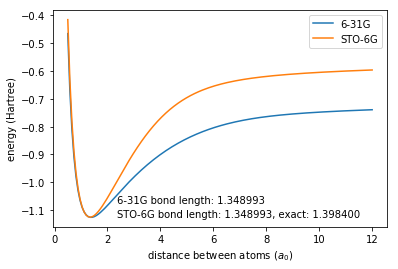

6-31G Bond Energy: 0.38724385549910034 (Hartree)
STO-6G Bond Energy: 0.5299338462619211 (Hartree)


In [97]:
# H2 bond distance
x = np.linspace(.5, 12, 150)
e = list()
t0 = time.time()
for i in x:
    ac = [(0, 0, 0), (0, 0, i)]
    e.append(main(Z, ac, 2, False))
t1 = time.time()
print('Time for 6-31G basis: {} (s)\nNumber of primitive gaussians: {}\n'.format(t1-t0, 8))

e1 = list()
basis_dict = basis_STO_6G
t0 = time.time()
for i in x:
    ac = [(0, 0, 0), (0, 0, i)]
    e1.append(main(Z, ac, 2, False))
t1 = time.time()
print('Time for STO-6G basis: {} (s)\nNumber of primitive gaussians: {}\n'.format(t1-t0, 12))

indx_min = np.argmin(e)
bond_length = x[indx_min]

plt.figure()
plt.plot(x, e, label='6-31G')
plt.plot(x, e1, label='STO-6G')
plt.xlabel('distance between atoms ($a_0$)')
plt.ylabel('energy (Hartree)')
plt.legend()
ax = plt.gca()
ax.text(bond_length+1, e[indx_min]+.05, '6-31G bond length: {:f}'.format(bond_length))
ax.text(bond_length+1, e1[indx_min], 'STO-6G bond length: {:f}, exact: {:f}'.format(bond_length, 1.3984))
plt.show()

print('6-31G Bond Energy: {} (Hartree)'.format(e[-1]-min(e)))
print('STO-6G Bond Energy: {} (Hartree)'.format(e1[-1]-min(e1)))

Note the accuracy in the bond length calculation.

Does the computational effort (time required) scale like you would expect?

What about the bond energies; are these correct? [Answer: No. Restricted Hartree-Fock does not take into account correlation energy. Also, you would need to know/calcluate the zero point energy. But it is the neglect of the correlation energy that produces the main source of the error.]

